In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *
from pdfo import *

In [2]:
n = 500
taux = 1/n

In [3]:
def Unicycle_DOC ( Xi , Xf , c1 , c2) :
    x1i = Xi[0] 
    x2i = Xi[1]
    x3i = Xi[2]
    
    x1f = Xf[0] 
    x2f = Xf[1]
    x3f = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux/2)*(c1*dot(u1,u1)+c2*dot(u2,u2))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x1[0]==x1i + 10**(-4))        
    opti.subject_to( x2[0]==x2i + 10**(-4))
    opti.subject_to( x3[0]==x3i + 10**(-4))
    
    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )

    opti.subject_to( u1[-1] == 0.0001)
    opti.subject_to( u2[-1] == 0.0001)

    ## pour les contraintes d'égaliter
    opti.subject_to( x1[:n-1]+taux*u1[:n-1]*cos(x3[:n-1])==x1[1:] + 10**(-4))
    opti.subject_to( x2[:n-1]+taux*u1[:n-1]*sin(x3[:n-1])==x2[1:] + 10**(-4))
    opti.subject_to( x3[:n-1]+taux*u2[:n-1] ==x3[1:] + 10**(-4))

    ## pour les conditions finales
    opti.subject_to( x1[-1]==x1f + 10**(-4))
    opti.subject_to( x2[-1]==x2f + 10**(-4))
    opti.subject_to( x3[-1]==x3f + 10**(-4))


    p_opts = dict(print_time = False, verbose = False)
    s_opts = dict(print_level = 0)


    opti.solver('ipopt', p_opts,s_opts)


    sol = opti.solve()
    
    X1 = sol.value(x1)
    X2 = sol.value(x2)
    X3 = sol.value(x3)
    
    U1 = sol.value(u1)
    U2 = sol.value(u2)
    
    return X1,X2,X3,U1,U2

In [12]:
bounds = np.array([[0, 1], [0, 1]])
lin_con = LinearConstraint([1, 1], 1, 1)

options = {'maxfev': 300 , 'rhobeg' : 0.01 , 'rhoend' : 1e-6}


def Unicycle (C) :
    [C1,C2] = C
    print(C)
    
    mk = 0
    
    if C1 < 0 : 
        C01 = - C1
        mk = mk + C01
    else :
        C01 = C1
    
    if C2 < 0 : 
        C02 = - C2
        mk = mk + C02  
    else :
        C02 = C2
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux/2)*(C01*dot(u1,u1)+C02*dot(u2,u2))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x1[0]==X1[0] + 10**(-4))        
    opti.subject_to( x2[0]==X2[0] + 10**(-4))
    opti.subject_to( x3[0]==X3[0] + 10**(-4))
    
    opti.subject_to( u1[0] == 0.0001 )
    opti.subject_to( u2[0] == 0.0001 )
    opti.subject_to( u1[-1] == 0.0001)
    opti.subject_to( u2[-1] == 0.0001)
    

    ## pour les contraintes d'égaliter
    opti.subject_to( u1[:n-1]*cos(x3[:n-1])==(x1[1:] + 10**(-4) - x1[:n-1])/taux)
    opti.subject_to( u1[:n-1]*sin(x3[:n-1])==(x2[1:] + 10**(-4) - x2[:n-1])/taux)
    opti.subject_to( u2[:n-1] ==(x3[1:] + 10**(-4) - x3[:n-1])/taux)
    
    ## pour les conditions finales
    opti.subject_to( x1[-1]==X1[-1] + 10**(-4))
    opti.subject_to( x2[-1]==X2[-1] + 10**(-4))
    opti.subject_to( x3[-1]==X3[-1] + 10**(-4))
    
    opti.solver('ipopt', {"expand":True}, {"max_iter":10000})
    
    sol = opti.solve() 
    
    X1_1 = opti.debug.value(x1)
    X2_1 = opti.debug.value(x2)
    X3_1 = opti.debug.value(x3)
    
    plt.plot(X1_1,X2_1, color = 'green')
    
    m01 = sqrt((np.linalg.norm(X1-X1_1)**2 + np.linalg.norm(X2-X2_1)**2 + np.linalg.norm(X3-X3_1)**2 )/n)
    m02 = 10* abs(C1+C2 - 1)
    m03 = 10* mk
    
    m1 = m01+m02+m03
    
    return m1   

In [13]:
Xi = [-4,-0.9,pi]
Xf = [0,0,pi/2]
c1 = 0.25
c2 = 0.75

X1,X2,X3,U1,U2 = Unicycle_DOC ( Xi , Xf , c1 , c2)

[0.5 0.5]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 

  18  1.2158642e+01 9.07e-12 5.86e-04  -5.7 8.56e-06   1.8 1.00e+00 1.00e+00h  1
  19  1.2158640e+01 8.11e-11 5.86e-04  -5.7 2.57e-05   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2158634e+01 7.30e-10 5.86e-04  -5.7 7.70e-05   0.9 1.00e+00 1.00e+00h  1
  21  1.2158617e+01 6.57e-09 5.86e-04  -5.7 2.31e-04   0.4 1.00e+00 1.00e+00h  1
  22  1.2158567e+01 5.92e-08 5.86e-04  -5.7 6.93e-04  -0.1 1.00e+00 1.00e+00h  1
  23  1.2158416e+01 5.32e-07 5.86e-04  -5.7 2.08e-03  -0.5 1.00e+00 1.00e+00h  1
  24  1.2157965e+01 4.79e-06 5.85e-04  -5.7 6.22e-03  -1.0 1.00e+00 1.00e+00h  1
  25  1.2156630e+01 4.30e-05 5.82e-04  -5.7 1.86e-02  -1.5 1.00e+00 1.00e+00h  1
  26  1.2152776e+01 3.86e-04 5.76e-04  -5.7 5.51e-02  -2.0 1.00e+00 1.00e+00h  1
  27  1.2142400e+01 3.45e-03 5.62e-04  -5.7 1.61e-01  -2.5 1.00e+00 1.00e+00h  1
  28  1.2120451e+01 3.12e-02 5.47e-04  -5.7 4.69e-01  -2.9 1.00e+00 1.00e+00h  1
  29  1.1989653e+01 2.46e-02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  17  1.1918864e+01 7.45e-13 5.26e-04  -3.8 2.56e-06   2.3 1.00e+00 1.00e+00h  1
  18  1.1918863e+01 8.70e-12 5.74e-04  -5.7 8.38e-06   1.8 1.00e+00 1.00e+00h  1
  19  1.1918862e+01 7.79e-11 5.74e-04  -5.7 2.51e-05   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1918856e+01 7.00e-10 5.74e-04  -5.7 7.54e-05   0.9 1.00e+00 1.00e+00h  1
  21  1.1918840e+01 6.30e-09 5.74e-04  -5.7 2.26e-04   0.4 1.00e+00 1.00e+00h  1
  22  1.1918792e+01 5.67e-08 5.74e-04  -5.7 6.79e-04  -0.1 1.00e+00 1.00e+00h  1
  23  1.1918647e+01 5.11e-07 5.74e-04  -5.7 2.04e-03  -0.5 1.00e+00 1.00e+00h  1
  24  1.1918215e+01 4.59e-06 5.73e-04  -5.7 6.10e-03  -1.0 1.00e+00 1.00e+00h  1
  25  1.1916934e+01 4.13e-05 5.71e-04  -5.7 1.82e-02  -1.5 1.00e+00 1.00e+00h  1
  26  1.1913233e+01 3.70e-04 5.64e-04  -5.7 5.40e-02  -2.0 1.00e+00 1.00e+00h  1
  27  1.1903251e+01 3.31e-03 5.50e-04  -5.7 1.58e-01  -2.5 1.00e+00 1.00e+00h  1
  28  1.1881949e+01 2.99e-02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  18  1.2003047e+01 9.85e-12 5.98e-04  -5.7 8.73e-06   1.8 1.00e+00 1.00e+00h  1
  19  1.2003045e+01 8.85e-11 5.98e-04  -5.7 2.62e-05   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2003039e+01 7.96e-10 5.98e-04  -5.7 7.86e-05   0.9 1.00e+00 1.00e+00h  1
  21  1.2003020e+01 7.16e-09 5.98e-04  -5.7 2.36e-04   0.4 1.00e+00 1.00e+00h  1
  22  1.2002965e+01 6.45e-08 5.98e-04  -5.7 7.07e-04  -0.1 1.00e+00 1.00e+00h  1
  23  1.2002800e+01 5.80e-07 5.98e-04  -5.7 2.12e-03  -0.5 1.00e+00 1.00e+00h  1
  24  1.2002307e+01 5.22e-06 5.97e-04  -5.7 6.35e-03  -1.0 1.00e+00 1.00e+00h  1
  25  1.2000847e+01 4.68e-05 5.95e-04  -5.7 1.90e-02  -1.5 1.00e+00 1.00e+00h  1
  26  1.1996641e+01 4.18e-04 5.90e-04  -5.7 5.65e-02  -2.0 1.00e+00 1.00e+00h  1
  27  1.1985367e+01 3.71e-03 5.78e-04  -5.7 1.66e-01  -2.5 1.00e+00 1.00e+00h  1
  28  1.1961607e+01 3.32e-02 5.64e-04  -5.7 4.84e-01  -2.9 1.00e+00 1.00e+00h  1
  29  1.1823982e+01 2.66e-02

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.8282886e-02 3.75e+00 2.61e+03  -1.0 4.07e+00    -  1.00e+00 

  14  1.2708253e+01 1.80e+00 6.06e-03  -3.8 4.02e+00    -  1.00e+00 1.00e+00h  1
  15  1.1956698e+01 1.15e-02 4.69e+02  -3.8 2.54e-01   3.3 1.00e+00 1.00e+00h  1
  16  1.1955618e+01 3.05e-06 2.61e+00  -3.8 4.23e-03   2.8 1.00e+00 1.00e+00h  1
  17  1.1955623e+01 8.68e-13 5.64e-04  -3.8 2.75e-06   2.3 1.00e+00 1.00e+00h  1
  18  1.1955623e+01 1.03e-11 6.24e-04  -5.7 9.10e-06   1.8 1.00e+00 1.00e+00h  1
  19  1.1955621e+01 9.23e-11 6.24e-04  -5.7 2.73e-05   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1955614e+01 8.31e-10 6.24e-04  -5.7 8.19e-05   0.9 1.00e+00 1.00e+00h  1
  21  1.1955595e+01 7.48e-09 6.23e-04  -5.7 2.46e-04   0.4 1.00e+00 1.00e+00h  1
  22  1.1955537e+01 6.73e-08 6.23e-04  -5.7 7.37e-04  -0.1 1.00e+00 1.00e+00h  1
  23  1.1955365e+01 6.06e-07 6.23e-04  -5.7 2.21e-03  -0.5 1.00e+00 1.00e+00h  1
  24  1.1954850e+01 5.45e-06 6.22e-04  -5.7 6.62e-03  -1.0 1.00e+00 1.00e+00h  1
  25  1.1953324e+01 4.90e-05

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.8110419e-02 3.75e+00 2.61e+03  -1.0 4.07e+00    -  1.00e+00 6.25e-02h  5
   2  7.7677284e-02 3.52e+00 7.56e+03  -1.0 6.49e+00   4.0 1.00e+00 6.25e-02h  5
   3  2.8799829e-01 3.30e+00 9.79e+03  -1.0 1.27e+01   3.5 1.00e+00 6.25e-02h  5
   4  8.4038370e-0

  17  1.1862867e+01 1.42e-12 8.06e-04  -3.8 3.92e-06   2.3 1.00e+00 1.00e+00h  1
  18  1.1862866e+01 1.20e-11 6.73e-04  -5.7 9.82e-06   1.8 1.00e+00 1.00e+00h  1
  19  1.1862863e+01 1.08e-10 6.73e-04  -5.7 2.95e-05   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1862856e+01 9.71e-10 6.73e-04  -5.7 8.84e-05   0.9 1.00e+00 1.00e+00h  1
  21  1.1862833e+01 8.74e-09 6.73e-04  -5.7 2.65e-04   0.4 1.00e+00 1.00e+00h  1
  22  1.1862765e+01 7.87e-08 6.73e-04  -5.7 7.95e-04  -0.1 1.00e+00 1.00e+00h  1
  23  1.1862562e+01 7.08e-07 6.73e-04  -5.7 2.39e-03  -0.5 1.00e+00 1.00e+00h  1
  24  1.1861956e+01 6.37e-06 6.72e-04  -5.7 7.15e-03  -1.0 1.00e+00 1.00e+00h  1
  25  1.1860160e+01 5.73e-05 6.69e-04  -5.7 2.14e-02  -1.5 1.00e+00 1.00e+00h  1
  26  1.1854975e+01 5.15e-04 6.63e-04  -5.7 6.35e-02  -2.0 1.00e+00 1.00e+00h  1
  27  1.1840975e+01 4.64e-03 6.51e-04  -5.7 1.87e-01  -2.5 1.00e+00 1.00e+00h  1
  28  1.1810903e+01 4.30e-02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  19  1.1532588e+01 1.75e-10 8.62e-04  -5.7 3.78e-05   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1532575e+01 1.58e-09 8.62e-04  -5.7 1.13e-04   0.9 1.00e+00 1.00e+00h  1
  21  1.1532537e+01 1.42e-08 8.62e-04  -5.7 3.40e-04   0.4 1.00e+00 1.00e+00h  1
  22  1.1532421e+01 1.28e-07 8.62e-04  -5.7 1.02e-03  -0.1 1.00e+00 1.00e+00h  1
  23  1.1532075e+01 1.15e-06 8.62e-04  -5.7 3.06e-03  -0.5 1.00e+00 1.00e+00h  1
  24  1.1531042e+01 1.03e-05 8.61e-04  -5.7 9.16e-03  -1.0 1.00e+00 1.00e+00h  1
  25  1.1527990e+01 9.33e-05 8.59e-04  -5.7 2.74e-02  -1.5 1.00e+00 1.00e+00h  1
  26  1.1519209e+01 8.44e-04 8.52e-04  -5.7 8.16e-02  -2.0 1.00e+00 1.00e+00h  1
  27  1.1495544e+01 7.73e-03 8.42e-04  -5.7 2.42e-01  -2.5 1.00e+00 1.00e+00h  1
  28  1.1443930e+01 7.51e-02 8.50e-04  -5.7 7.28e-01  -2.9 1.00e+00 1.00e+00h  1
  29  1.1111976e+01 2.14e-01 4.39e-03  -5.7 2.66e+00  -3.4 1.00e+00 1.00e+00H  1
iter    objective    inf_pr 

   1  1.6242874e-02 3.75e+00 2.61e+03  -1.0 4.07e+00    -  1.00e+00 6.25e-02h  5
   2  7.1443959e-02 3.52e+00 7.56e+03  -1.0 6.49e+00   4.0 1.00e+00 6.25e-02h  5
   3  2.8161120e-01 3.30e+00 9.79e+03  -1.0 1.27e+01   3.5 1.00e+00 6.25e-02h  5
   4  8.3701987e-01 2.88e+00 1.30e+04  -1.0 7.76e+00   3.9 1.00e+00 1.25e-01h  4
   5  1.6229288e+00 2.52e+00 3.18e+04  -1.0 6.91e+00   4.4 1.00e+00 1.25e-01h  4
   6  2.4987742e+00 2.21e+00 3.21e+04  -1.0 5.57e+00   3.9 1.00e+00 1.25e-01h  4
   7  3.4408477e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3329987e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3561535e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3729988e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.3732029e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3732028e+01 2.24e-13

  24  1.1170825e+01 5.64e-04 1.63e-01  -5.7 6.44e-02   0.4 1.00e+00 1.00e+00h  1
  25  1.1170259e+01 1.87e-07 9.89e-04  -5.7 1.17e-03  -0.1 1.00e+00 1.00e+00h  1
  26  1.1169299e+01 1.39e-06 1.04e-03  -5.7 3.69e-03  -0.5 1.00e+00 1.00e+00h  1
  27  1.1166446e+01 1.25e-05 1.03e-03  -5.7 1.10e-02  -1.0 1.00e+00 1.00e+00h  1
  28  1.1158140e+01 1.14e-04 1.01e-03  -5.7 3.22e-02  -1.5 1.00e+00 1.00e+00h  1
  29  1.1135205e+01 1.05e-03 9.45e-04  -5.7 9.05e-02  -2.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1079203e+01 9.81e-03 7.92e-04  -5.7 2.27e-01  -2.5 1.00e+00 1.00e+00h  1
  31  1.0973191e+01 9.54e-02 8.35e-04  -5.7 7.13e-01  -2.9 1.00e+00 1.00e+00h  1
  32  1.0526575e+01 2.90e-01 4.58e-03  -5.7 2.81e+00  -3.4 1.00e+00 1.00e+00H  1
  33  1.0387551e+01 7.39e-01 5.63e-03  -5.7 1.10e+02  -3.9 1.00e+00 1.56e-02f  7
  34  1.0096758e+01 1.13e+00 5.23e-03  -5.7 7.78e+00  -3.5 1.00e+00 2.50e-01h  3
  35  9.1600326e+00 8.14e-01

   2  5.8418609e-02 3.52e+00 7.56e+03  -1.0 6.49e+00   4.0 1.00e+00 6.25e-02h  5
   3  2.6826453e-01 3.30e+00 9.79e+03  -1.0 1.27e+01   3.5 1.00e+00 6.25e-02h  5
   4  8.2999068e-01 2.88e+00 1.30e+04  -1.0 7.76e+00   3.9 1.00e+00 1.25e-01h  4
   5  1.6337418e+00 2.52e+00 3.18e+04  -1.0 6.91e+00   4.4 1.00e+00 1.25e-01h  4
   6  2.5099960e+00 2.21e+00 3.21e+04  -1.0 5.57e+00   3.9 1.00e+00 1.25e-01h  4
   7  3.4612208e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3227015e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3745975e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3944394e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.3945743e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3945742e+01 2.18e-13 4.27e-03  -1.0 7.70e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3924304e+01 6.48e+00

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2506476e-02 3.75e+00 2.61e+03  -1.0 4.07e+00    -  1.00e+00 6.25e-02h  5
   2  5.9128889e-02 3.52e+00 7.56e+03  -1.0 6.49e+00   4.0 1.00e+00 6.25e-02h  5
   3  2.7087859e-01 3.30e+00 9.79e+03  -1.0 1.27e+01   3.5 1.00e+00 6.25e-02h  5
   4  8.3760086e-0

  26  7.6928866e+00 6.32e-04 2.88e-01  -3.8 4.43e-02  -0.1 1.00e+00 1.00e+00h  1
  27  7.6904290e+00 6.59e-06 1.34e-03  -3.8 4.71e-03  -0.5 1.00e+00 1.00e+00h  1
  28  7.5620659e+00 2.07e+00 2.89e-03  -5.7 5.94e+01    -  1.00e+00 6.25e-02f  5
  29  7.2796856e+00 2.52e+00 3.15e-03  -5.7 1.31e+01    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.1213478e+00 2.63e-01 1.77e-03  -5.7 1.82e+00    -  1.00e+00 1.00e+00h  1
  31  6.0255391e+00 3.13e-02 3.52e-05  -5.7 5.44e-01    -  1.00e+00 1.00e+00h  1
  32  6.0143450e+00 1.95e-05 2.63e-08  -5.7 1.06e-02    -  1.00e+00 1.00e+00h  1
  33  6.0143428e+00 1.41e-11 1.27e-13  -8.6 1.85e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   6.0143428013101037e+00    6.0143428013101037e+00
Dual infeasibility......:   1.2656542480726785e-13    1.2656542480726785e-13
Constraint viol

   7  3.4684503e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3190475e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3811425e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4020477e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.4021581e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.4021581e+01 2.17e-13 4.57e-03  -1.0 8.24e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3891915e+01 5.23e+00 9.34e-03  -3.8 3.07e+01    -  1.00e+00 2.50e-01f  3
  14  1.1321164e+01 1.92e-01 2.34e+03  -3.8 1.21e+00   3.3 1.00e+00 1.00e+00h  1
  15  1.1219531e+01 1.83e-03 2.90e+02  -3.8 6.57e-02   2.8 1.00e+00 1.00e+00h  1
  16  1.1221714e+01 1.80e-07 2.02e-01  -3.8 9.82e-04   2.3 1.00e+00 1.00e+00h  1
  17  1.1221686e+01 1.22e-10 3.15e-03  -3.8 4.59e-05   1.8 1.00e+00 1.00e+00h  1
  18  1.0993657e+01 1.32e+00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

  27  1.0279422e+01 3.02e-02 2.26e-03  -3.8 6.47e-01  -2.5 1.00e+00 1.00e+00h  1
  28  9.6988877e+00 2.36e-01 1.65e-03  -3.8 1.39e+00  -2.9 1.00e+00 1.00e+00h  1
  29  9.4173985e+00 2.32e+00 4.53e-03  -3.8 3.76e+00  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.0070591e+00 5.08e-01 1.87e-03  -3.8 1.67e+00  -3.0 1.00e+00 1.00e+00h  1
  31  7.8602165e+00 2.70e+00 4.99e-03  -3.8 4.97e+02    -  1.00e+00 7.81e-03f  8
  32  7.5427819e+00 3.00e+00 5.32e-03  -3.8 1.38e+02    -  1.00e+00 1.56e-02h  7
  33  7.2022900e+00 2.78e+00 3.82e-03  -3.8 1.38e+01    -  1.00e+00 2.50e-01h  3
  34  5.7146276e+00 5.73e-02 6.78e-04  -3.8 2.40e+00    -  1.00e+00 1.00e+00h  1
  35  5.6902547e+00 2.77e-03 3.84e-06  -3.8 1.76e-01    -  1.00e+00 1.00e+00h  1
  36  5.6898540e+00 1.10e-07 2.70e-10  -5.7 1.06e-03    -  1.00e+00 1.00e+00h  1
  37  5.6898540e+00 2.11e-13 1.33e-15  -9.0 9.90e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

   4  8.2702380e-01 2.88e+00 1.30e+04  -1.0 7.76e+00   3.9 1.00e+00 1.25e-01h  4
   5  1.6341897e+00 2.52e+00 3.18e+04  -1.0 6.91e+00   4.4 1.00e+00 1.25e-01h  4
   6  2.5093089e+00 2.21e+00 3.21e+04  -1.0 5.57e+00   3.9 1.00e+00 1.25e-01h  4
   7  3.4615229e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3139616e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3773584e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3979367e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.3980538e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3980537e+01 2.31e-13 4.48e-03  -1.0 8.07e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3221322e+01 3.30e+00 5.26e-03  -3.8 2.40e+01    -  1.00e+00 2.50e-01f  3
  14  1.1640915e+01 7.51e-02 1.38e+03  -3.8 7.44e-01   3.3 1.00e+00 1.00e+00h  1
  15  1.1602809e+01 2.74e-04

  36  5.7199852e+00 1.27e-05 1.97e-07  -3.8 2.10e-02    -  1.00e+00 1.00e+00h  1
  37  5.7199819e+00 4.32e-10 8.08e-13  -8.6 6.00e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.7199818676757728e+00    5.7199818676757728e+00
Dual infeasibility......:   8.0824236192711396e-13    8.0824236192711396e-13
Constraint violation....:   8.6345286476330337e-11    4.3172643238165165e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   8.6345286476330337e-11    4.3172643238165165e-10


Number of objective function evaluations             = 103
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 103
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian 

  11  1.3992673e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3992672e+01 2.19e-13 4.46e-03  -1.0 8.03e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3135548e+01 2.89e+00 4.48e-03  -3.8 2.23e+01    -  1.00e+00 2.50e-01f  3
  14  1.1762805e+01 5.65e-02 1.19e+03  -3.8 6.45e-01   3.3 1.00e+00 1.00e+00h  1
  15  1.1734378e+01 1.55e-04 4.36e+01  -3.8 2.30e-02   2.8 1.00e+00 1.00e+00h  1
  16  1.1734580e+01 1.38e-09 2.01e-02  -3.8 9.76e-05   2.3 1.00e+00 1.00e+00h  1
  17  1.1734553e+01 1.28e-10 3.16e-03  -3.8 4.62e-05   1.8 1.00e+00 1.00e+00h  1
  18  1.1360288e+01 7.12e-01 2.99e-03  -3.8 3.92e+01    -  1.00e+00 6.25e-02f  5
  19  1.1013671e+01 4.08e-03 3.80e+00  -3.8 1.66e-01   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.1011614e+01 6.17e-07 1.15e-02  -3.8 1.50e-03   0.9 1.00e+00 1.00e+00h  1
  21  1.1010972e+01 7.15e-08 2.81e-03  -3.8 1.11e-03   0.4 1.00e+00 1.00e+00h  1
  22  1.0893244e+01 1.27e+00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0899702e+01 1.06e-06 1.53e-02  -3.8 2.01e-03   0.9 1.00e+00 1.00e+00h  1
  21  1.0899057e+01 6.96e-08 2.79e-03  -3.8 1.10e-03   0.4 1.00e+00 1.00e+00h  1
  22  1.0897121e+01 6.25e-07 2.79e-03  -3.8 3.30e-03  -0.1 1.00e+00 1.00e+00h  1
  23  1.0891335e+01 5.62e-06 2.78e-03  -3.8 9.87e-03  -0.5 1.00e+00 1.00e+00h  1
  24  1.0874156e+01 5.02e-05 2.77e-03  -3.8 2.95e-02  -1.0 1.00e+00 1.00e+00h  1
  25  1.0824186e+01 4.44e-04 2.72e-03  -3.8 8.68e-02  -1.5 1.00e+00 1.00e+00h  1
  26  1.0686871e+01 3.79e-03 2.59e-03  -3.8 2.48e-01  -2.0 1.00e+00 1.00e+00h  1
  27  1.0360063e+01 3.04e-02 2.26e-03  -3.8 6.48e-01  -2.5 1.00e+00 1.00e+00h  1
  28  9.7914393e+00 2.32e-01 1.65e-03  -3.8 1.39e+00  -2.9 1.00e+00 1.00e+00h  1
  29  9.4994027e+00 2.20e+00 4.31e-03  -3.8 3.67e+00  -3.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.1649008e+00 4.73e-01

[0.24992855 0.75007145]
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     5499
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1998

Total number of variables............................:     2500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1507
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00  

  21  1.0965809e+01 7.07e-08 2.80e-03  -3.8 1.11e-03   0.4 1.00e+00 1.00e+00h  1
  22  1.0748353e+01 5.05e-01 2.81e-03  -3.8 1.04e+03    -  1.00e+00 1.95e-03f 10
  23  1.0498277e+01 2.21e-03 1.02e-01  -3.8 1.21e-01  -0.1 1.00e+00 1.00e+00h  1
  24  1.0491718e+01 5.53e-06 2.62e-03  -3.8 9.21e-03  -0.5 1.00e+00 1.00e+00h  1
  25  1.0474594e+01 4.86e-05 2.62e-03  -3.8 2.78e-02  -1.0 1.00e+00 1.00e+00h  1
  26  1.0424767e+01 4.31e-04 2.57e-03  -3.8 8.21e-02  -1.5 1.00e+00 1.00e+00h  1
  27  1.0287733e+01 3.74e-03 2.45e-03  -3.8 2.35e-01  -2.0 1.00e+00 1.00e+00h  1
  28  9.9604836e+00 3.02e-02 2.15e-03  -3.8 6.14e-01  -2.5 1.00e+00 1.00e+00h  1
  29  9.3847183e+00 2.33e-01 1.57e-03  -3.8 1.32e+00  -2.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.1903630e+00 2.65e+00 5.34e-03  -3.8 3.96e+00  -3.4 1.00e+00 1.00e+00h  1
  31  7.5742285e+00 5.93e-01 2.41e-03  -3.8 1.77e+00  -3.0 1.00e+00 1.00e+00h  1
  32  7.2566762e+00 2.02e+00

   2  5.5403327e-02 3.52e+00 7.56e+03  -1.0 6.49e+00   4.0 1.00e+00 6.25e-02h  5
   3  2.6514738e-01 3.30e+00 9.79e+03  -1.0 1.27e+01   3.5 1.00e+00 6.25e-02h  5
   4  8.2825819e-01 2.88e+00 1.30e+04  -1.0 7.76e+00   3.9 1.00e+00 1.25e-01h  4
   5  1.6360232e+00 2.52e+00 3.18e+04  -1.0 6.91e+00   4.4 1.00e+00 1.25e-01h  4
   6  2.5122562e+00 2.21e+00 3.21e+04  -1.0 5.57e+00   3.9 1.00e+00 1.25e-01h  4
   7  3.4654686e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3197540e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3786750e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3992062e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.3993251e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3993251e+01 2.15e-13 4.47e-03  -1.0 8.05e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3162522e+01 3.01e+00

  31  7.3014863e+00 6.24e-01 2.79e-03  -3.8 1.80e+00  -3.0 1.00e+00 1.00e+00h  1
  32  7.0097175e+00 2.14e+00 3.78e-03  -3.8 1.38e+01    -  1.00e+00 2.50e-01h  3
  33  6.6186108e+00 1.09e+00 1.16e-02  -3.8 6.11e+00    -  1.00e+00 1.00e+00H  1
  34  6.0519370e+00 1.03e+00 2.21e-03  -3.8 3.16e+00    -  1.00e+00 1.00e+00h  1
  35  5.7168688e+00 5.13e-02 6.30e-05  -3.8 5.10e-01    -  1.00e+00 1.00e+00h  1
  36  5.7115971e+00 1.57e-05 2.44e-07  -3.8 2.39e-02    -  1.00e+00 1.00e+00h  1
  37  5.7115931e+00 6.99e-10 1.35e-12  -8.6 7.65e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.7115930738140630e+00    5.7115930738140630e+00
Dual infeasibility......:   1.3544720900426910e-12    1.3544720900426910e-12
Constraint violation....:   1.3981633628645796e-10    6.9908168143228977e-10
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity........

   4  8.2837181e-01 2.88e+00 1.30e+04  -1.0 7.76e+00   3.9 1.00e+00 1.25e-01h  4
   5  1.6362321e+00 2.52e+00 3.18e+04  -1.0 6.91e+00   4.4 1.00e+00 1.25e-01h  4
   6  2.5125805e+00 2.21e+00 3.21e+04  -1.0 5.57e+00   3.9 1.00e+00 1.25e-01h  4
   7  3.4659129e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3203300e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3788453e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3993773e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.3994963e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3994962e+01 2.29e-13 4.47e-03  -1.0 8.05e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3162581e+01 3.01e+00 4.69e-03  -3.8 2.28e+01    -  1.00e+00 2.50e-01f  3
  14  1.1732281e+01 6.14e-02 1.24e+03  -3.8 6.72e-01   3.3 1.00e+00 1.00e+00h  1
  15  1.1701324e+01 1.83e-04

  37  5.7112921e+00 1.42e-12 2.66e-15  -8.6 3.18e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.7112921202013185e+00    5.7112921202013185e+00
Dual infeasibility......:   2.6645352591003757e-15    2.6645352591003757e-15
Constraint violation....:   2.8368418725222003e-13    1.4184209362611000e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8368418725222003e-13    1.4184209362611000e-12


Number of objective function evaluations             = 107
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 110
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 38
Number of inequality constraint Jacobian evaluations = 0
Numbe

   2  5.5419547e-02 3.52e+00 7.56e+03  -1.0 6.49e+00   4.0 1.00e+00 6.25e-02h  5
   3  2.6519420e-01 3.30e+00 9.79e+03  -1.0 1.27e+01   3.5 1.00e+00 6.25e-02h  5
   4  8.2838263e-01 2.88e+00 1.30e+04  -1.0 7.76e+00   3.9 1.00e+00 1.25e-01h  4
   5  1.6362534e+00 2.52e+00 3.18e+04  -1.0 6.91e+00   4.4 1.00e+00 1.25e-01h  4
   6  2.5126132e+00 2.21e+00 3.21e+04  -1.0 5.57e+00   3.9 1.00e+00 1.25e-01h  4
   7  3.4659580e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3203864e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3788632e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3993954e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.3995145e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3995144e+01 2.31e-13 4.47e-03  -1.0 8.05e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3162743e+01 3.01e+00

  35  5.7104327e+00 6.94e-03 1.23e-05  -3.8 2.92e-01    -  1.00e+00 1.00e+00h  1
  36  5.7111407e+00 4.90e-06 3.52e-08  -5.7 9.48e-03    -  1.00e+00 1.00e+00h  1
  37  5.7111382e+00 1.77e-11 2.93e-14  -8.6 1.12e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.7111382499632128e+00    5.7111382499632128e+00
Dual infeasibility......:   2.9309887850104133e-14    2.9309887850104133e-14
Constraint violation....:   3.5368152850878690e-12    1.7684076425439343e-11
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.5368152850878690e-12    1.7684076425439343e-11


Number of objective function evaluations             = 106
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 108
Number of inequ

   5  1.6362320e+00 2.52e+00 3.18e+04  -1.0 6.91e+00   4.4 1.00e+00 1.25e-01h  4
   6  2.5125803e+00 2.21e+00 3.21e+04  -1.0 5.57e+00   3.9 1.00e+00 1.25e-01h  4
   7  3.4659127e+00 1.93e+00 4.11e+04  -1.0 4.96e+00   4.3 1.00e+00 1.25e-01h  4
   8  4.3203301e+00 1.69e+00 3.87e+04  -1.0 5.24e+00   3.8 1.00e+00 1.25e-01h  4
   9  1.3788451e+01 2.66e-01 2.68e+05  -1.0 3.82e+00   4.3 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3993771e+01 1.83e-03 9.08e+03  -1.0 7.98e-02   4.7 1.00e+00 1.00e+00h  1
  11  1.3994961e+01 3.03e-08 1.97e+01  -1.0 1.18e-03   4.2 1.00e+00 1.00e+00h  1
  12  1.3994960e+01 1.94e-13 4.47e-03  -1.0 8.05e-07   3.7 1.00e+00 1.00e+00h  1
  13  1.3162554e+01 3.01e+00 4.69e-03  -3.8 2.28e+01    -  1.00e+00 2.50e-01f  3
  14  1.1732310e+01 6.14e-02 1.24e+03  -3.8 6.72e-01   3.3 1.00e+00 1.00e+00h  1
  15  1.1701355e+01 1.83e-04 4.95e+01  -3.8 2.47e-02   2.8 1.00e+00 1.00e+00h  1
  16  1.1701594e+01 1.93e-09

  33  6.2223544e+00 1.06e+00 6.72e-03  -3.8 4.18e+00    -  1.00e+00 1.00e+00h  1
  34  5.8405015e+00 4.21e-01 4.47e-04  -3.8 2.08e+00    -  1.00e+00 1.00e+00h  1
  35  5.7114491e+00 2.67e-03 3.99e-06  -3.8 1.47e-01    -  1.00e+00 1.00e+00h  1
  36  5.7112350e+00 4.39e-07 3.35e-09  -5.7 2.97e-03    -  1.00e+00 1.00e+00h  1
  37  5.7112348e+00 2.05e-13 1.33e-15  -8.6 1.06e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   5.7112348035309006e+00    5.7112348035309006e+00
Dual infeasibility......:   1.3322676295501878e-15    1.3322676295501878e-15
Constraint violation....:   4.1078251911130792e-14    2.0539125955565396e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.1078251911130792e-14    2.0539125955565396e-13


Number of objective function 

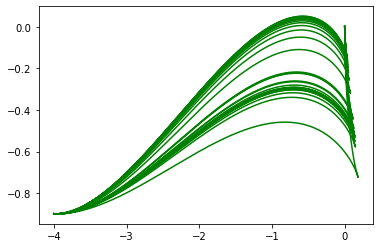

In [14]:
res = pdfo( Unicycle, [0.5, 0.5], bounds=bounds, constraints=[lin_con], options=options)
c1,c2= res.x



In [15]:
X1P_PDFO,X2P_PDFO,X3P_PDFO,U1P_PDFO,U2P_PDFO  = Unicycle_DOC ( Xi , Xf , c1 , c2)

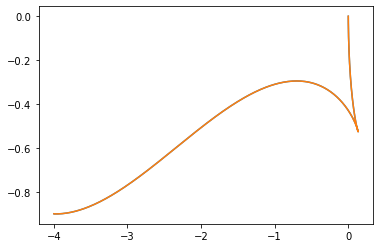

In [16]:
plt.plot(X1,X2)
plt.plot(X1P_PDFO,X2P_PDFO)